## Keyword Spotting with Graph Neural Network
Word utterances recognition network, trained on one-second wav audio clips from [Google Speech Command](https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html) dataset.

Execute the notebook with a GPU runtime.
<br><br>
Carlo Aironi<br>
c.aironi@pm.univpm.it<br>


Last update: 5/2025

## Import libraries

Google Colab currently doesn't include Pytorch Geometric as pre-installed package. In case of probems, see [documentation](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html) for the updated installation commands.

In [1]:
import torch
print(f'PyTorch version: {torch.__version__} - CUDA {torch.version.cuda}')

PyTorch version: 2.6.0+cu124 - CUDA 12.4


In [2]:
# # Install required packages.
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-$(python3 -c "import torch; print(torch.__version__.split('+')[0])")+cu$(python3 -c "import torch; print(torch.version.cuda.replace('.', ''))").html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 95.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.0 MB/s eta 0:00:00


In [4]:
import os
import glob
import time
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.nn import NNConv, graclus, max_pool, max_pool_x, global_mean_pool
from torch_sparse import coalesce
from torch_geometric.io import read_txt_array
from torch_geometric.utils import normalized_cut, remove_self_loops
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

## Parameters

In [5]:
# network global parameters
BATCH_SIZE = 32
EPOCHS = 250
LEARNING_RATE = 5e-4

classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

trainset_path = 'GSC10_T_hd'
valset_path = 'GSC10_V_hd'
saved_model = 'gnn_exp_1.pth'
saved_perf = 'gnn_exp_1.csv'

Define computation environment

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available environment: {device}')

Available environment: cuda


## Download data

In [7]:
# The data will be downloaded to a temporary folder
!wget -nc -O data.zip "https://drive.google.com/uc?export=download&id=1K8y7GcwYBggcwjbcbiXTWfsj9hUkiFnl"
!unzip -q data.zip

--2025-05-08 20:17:25--  https://drive.google.com/uc?export=download&id=1K8y7GcwYBggcwjbcbiXTWfsj9hUkiFnl
Resolving drive.google.com (drive.google.com)... 108.177.96.113, 108.177.96.139, 108.177.96.100, ...
Connecting to drive.google.com (drive.google.com)|108.177.96.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1K8y7GcwYBggcwjbcbiXTWfsj9hUkiFnl&export=download [following]
--2025-05-08 20:17:25--  https://drive.usercontent.google.com/download?id=1K8y7GcwYBggcwjbcbiXTWfsj9hUkiFnl&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.69.132, 2a00:1450:4013:c04::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.69.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15706986 (15M) [application/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>]  14.98M  85.6MB/s    in

## Generate graph dataset

Here graph domain dataset is loaded.

In [8]:
def cat(seq):
    seq = [item for item in seq if item is not None]
    seq = [item.unsqueeze(-1) if item.dim() == 1 else item for item in seq]
    return torch.cat(seq, dim=-1) if len(seq) > 0 else None

In [9]:
def split(data, batch):
    node_slice = torch.cumsum(torch.from_numpy(np.bincount(batch)), 0)
    node_slice = torch.cat([torch.tensor([0]), node_slice])

    row, _ = data.edge_index
    edge_slice = torch.cumsum(torch.from_numpy(np.bincount(batch[row])), 0)
    edge_slice = torch.cat([torch.tensor([0]), edge_slice])

    # Edge indices should start at zero for every graph.
    data.edge_index -= node_slice[batch[row]].unsqueeze(0)
    data.__num_nodes__ = torch.bincount(batch).tolist()

    slices = {'edge_index': edge_slice}
    if data.x is not None:
        slices['x'] = node_slice
    if data.edge_attr is not None:
        slices['edge_attr'] = edge_slice
    if data.y is not None:
        if data.y.size(0) == batch.size(0):
            slices['y'] = node_slice
        else:
            slices['y'] = torch.arange(0, batch[-1] + 2, dtype=torch.long)
    if data.pos is not None:
        slices['pos'] = node_slice
    # if data.ts is not None:
    #     slices['ts'] = node_slice

    return data, slices

In [10]:
def read_file(folder, prefix, name, dtype=None):
    path = os.path.join(folder, '{}_{}.txt'.format(prefix, name))
    return read_txt_array(path, sep=',', dtype=dtype)

In [11]:
def read_wav_embed(folder, prefix):
    files = glob.glob(os.path.join(folder, '{}_*.txt'.format(prefix)))
    names = [f.split(os.sep)[-1][len(prefix) + 1:-4] for f in files]
    print(names)
    edge_index = read_file(folder, prefix, 'A', torch.long).t() - 1
    print('Load A...')
    batch = read_file(folder, prefix, 'graph_indicator', torch.long) - 1
    print('Load GRAPH INDICATOR...')

    node_attributes = node_labels = None
    if 'node_attributes' in names:
        print('Load NODE ATTRIBUTES...')
        node_attributes = read_file(folder, prefix, 'node_attributes')

    if 'node_labels' in names:
        print('Load NODE LABELS...')
        node_labels = read_file(folder, prefix, 'node_labels', torch.long)
        if node_labels.dim() == 1:
            node_labels = node_labels.unsqueeze(-1)
        node_labels = node_labels - node_labels.min(dim=0)[0]
        node_labels = node_labels.unbind(dim=-1)
        node_labels = [F.one_hot(x, num_classes=-1) for x in node_labels]
        node_labels = torch.cat(node_labels, dim=-1).to(torch.float)
    x = cat([node_attributes, node_labels])

    pos = None
    if 'pos' in names:
        print('Load POS...')
        pos = read_file(folder, prefix, 'pos')

    ts = None
    if 'ts' in names:
        print('Load TS...')
        ts = read_file(folder, prefix, 'ts')

    edge_attributes, edge_labels = None, None
    if 'edge_attributes' in names:
        print('Load EDGE ATTRIBUTES...')
        edge_attributes = read_file(folder, prefix, 'edge_attributes')
    if 'edge_labels' in names:
        print('Load EDGE LABELS...')
        edge_labels = read_file(folder, prefix, 'edge_labels', torch.long)
        if edge_labels.dim() == 1:
            edge_labels = edge_labels.unsqueeze(-1)
        edge_labels = edge_labels - edge_labels.min(dim=0)[0]
        edge_labels = edge_labels.unbind(dim=-1)
        edge_labels = [F.one_hot(e, num_classes=-1) for e in edge_labels]
        edge_labels = torch.cat(edge_labels, dim=-1).to(torch.float)
    edge_attr = cat([edge_attributes, edge_labels])

    y = None
    if 'graph_attributes' in names:  # Regression problem.
        print('Load GRAPH ATTRIBUTES...')
        y = read_file(folder, prefix, 'graph_attributes')
    elif 'graph_labels' in names:  # Classification problem.
        print('Load GRAPH LABELS...')
        y = read_file(folder, prefix, 'graph_labels', torch.long)
        _, y = y.unique(sorted=True, return_inverse=True)

    num_nodes = edge_index.max().item() + 1 if x is None else x.size(0)
    edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
    edge_index, edge_attr = coalesce(edge_index, edge_attr, num_nodes, num_nodes)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, pos=pos, ts=ts)
    data, slices = split(data, batch)

    return data, slices

In [20]:
class WAVDataset(InMemoryDataset):

    def __init__(self, root, name, transform=None, pre_transform=None,
                 pre_filter=None, use_node_attr=True, use_edge_attr=False,
                 cleaned=False):
        self.name = name
        self.cleaned = cleaned
        super(WAVDataset, self).__init__(root, transform, pre_transform,pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)
        if self.data.x is not None and not use_node_attr:
            num_node_attributes = self.num_node_attributes
            self.data.x = self.data.x[:, num_node_attributes:]
        if self.data.edge_attr is not None and not use_edge_attr:
            num_edge_attributes = self.num_edge_attributes
            self.data.edge_attr = self.data.edge_attr[:, num_edge_attributes:]

    @property
    def num_node_labels(self):
        if self.data.x is None:
            return 0
        for i in range(self.data.x.size(1)):
            x = self.data.x[:, i:]
            if ((x == 0) | (x == 1)).all() and (x.sum(dim=1) == 1).all():
                return self.data.x.size(1) - i
        return 0

    @property
    def num_node_attributes(self):
        if self.data.x is None:
            return 0
        return self.data.x.size(1) - self.num_node_labels

    @property
    def num_edge_labels(self):
        if self.data.edge_attr is None:
            return 0
        for i in range(self.data.edge_attr.size(1)):
            if self.data.edge_attr[:, i:].sum() == self.data.edge_attr.size(0):
                return self.data.edge_attr.size(1) - i
        return 0

    @property
    def num_edge_attributes(self):
        if self.data.edge_attr is None:
            return 0
        return self.data.edge_attr.size(1) - self.num_edge_labels

    @property
    def raw_file_names(self):
        names = ['A', 'graph_indicator']
        return ['{}_{}.txt'.format(self.name, name) for name in names]

    @property
    def processed_file_names(self):
        return 'data.pt'

    def download(self):
        print('Use local dataset, no need to download')
        pass

    def process(self):
        self.data, self.slices = read_wav_embed(self.raw_dir, self.name)

        if self.pre_filter is not None:
            data_list = [self.get(idx) for idx in range(len(self))]
            data_list = [data for data in data_list if self.pre_filter(data)]
            self.data, self.slices = self.collate(data_list)

        if self.pre_transform is not None:
            data_list = [self.get(idx) for idx in range(len(self))]
            data_list = [self.pre_transform(data) for data in data_list]
            self.data, self.slices = self.collate(data_list)

        torch.save((self.data, self.slices), self.processed_paths[0])

    def __repr__(self):
        return '{}({})'.format(self.name, len(self))


In [21]:
def data_load():
    """
    Load graph data and create dataloaders

    """

    # load dataset from csv files
    print('Load new instance of dataset')

    transform = T.Cartesian(cat=False)

    train_dataset = WAVDataset(root = trainset_path,
                               name = trainset_path,
                               transform = transform,
                               use_node_attr = True)

    val_dataset = WAVDataset(root = valset_path,
                             name = valset_path,
                             transform = transform,
                             use_node_attr = True)

    # create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    return train_loader, val_loader

## Network model



The GNN network model is defined similarly to any PyTorch model, using pre-built functions of PyTorch Geometric library.

Here the __NNConv__ convolutional operator from _“Dynamic Edge-Conditioned Filters in Convolutional Neural Networks on Graphs”_ is used. It implements a spatial-based convolution described by the following message passing function:

$x_{i}^{'}=\Theta x_{i}+\sum_{j\in\mathcal{N}(i)}x_{j}\cdot h_{\Theta}\left( \text{e}_{i,j} \right)$

where:

- $x_{i}^{'}$ is the updated attribute vector of node $i$,
- $x_{i}$ is the attribute vector of node $i$ at previous step,
- $x_{j}$  $j{\in}\mathcal{N(i)}$ is the set of the neighboring nodes of node $i$
- $\Theta$ is the node-level learnable weight matrix,
- $h_{\theta}$ denotes a neural network, represented below by the MLPs `nn1` and `nn2`
- $e_{i,j}$ is the _edge attribute_ between nodes $i$ and $j$, computed as the euclidean distance.

Attribute space input dimension is equal to $\mathbb{R}^{5}$, which is the number of geometric region descriptors (_Area_, _Perimeter_, _Orientation_, _Eccentricity_ and _Solidity_). Node embedding is then mapped to $\mathbb{R}^{32}$ after the first conv layer, and to $\mathbb{R}^{64}$ after the second one.

Between each NNConv layer, a _clustering_ of nodes in pairs is performed, based on proximity in the attribute space; and then a _pooling_ which replaces each pair of nodes with just one.

After the convolutional block, a _readout_ MLP with one hidden layer of 128 neurons, performs associations to class labels.

In [22]:
class GNNNet(nn.Module):
    def __init__(self):
        super(GNNNet, self).__init__()
        # the output of nn1 must be equal to in_chan * out_chan of the respective NNConv layer
        nn1 = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Dropout(), nn.Linear(64, 160))
        self.conv1 = NNConv(5, 32, nn1, aggr='mean')

        nn2 = nn.Sequential(nn.Linear(3, 128), nn.ReLU(), nn.Dropout(), nn.Linear(128, 2048))
        self.conv2 = NNConv(32, 64, nn2, aggr='mean')

        self.fc1 = torch.nn.Linear(64, 128)

        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, data):

        data.x = F.elu(self.conv1(data.x, data.edge_index, data.edge_attr))
        weight = normalized_cut_3d(data.edge_index, data.pos)
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        data.edge_attr = None
        data = max_pool(cluster, data, transform = T.Cartesian(cat=False))

        data.x = F.elu(self.conv2(data.x, data.edge_index, data.edge_attr))
        weight = normalized_cut_3d(data.edge_index, data.pos)
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        x, batch = max_pool_x(cluster, data.x, data.batch)

        x = global_mean_pool(x, batch)

        x = F.elu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


In [23]:
def normalized_cut_3d(edge_index, pos):
    row, col = edge_index
    edge_attr = torch.norm(pos[row] - pos[col], p=2, dim=1)
    return normalized_cut(edge_index, edge_attr, num_nodes=pos.size(0))

## Helper functions

In [24]:
def plot_curve(train_accs, val_accs, train_losss, val_losss):
    plt.figure(1, figsize=[10, 6])

    plt.subplot(211)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epochs')
    # plt.ylim([0.25, 1])
    plt.legend(loc='lower right')

    plt.subplot(212)
    plt.plot(train_losss, label='Train Loss')
    plt.plot(val_losss, label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    # plt.ylim([0.0, 2.5])
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


def plot_cmatrix(confusion_loader, model, device, normalize):
    # Plot normalized confusion matrix on validation set
    model.eval()
    datay_all = torch.tensor([], dtype=torch.int64).to(device)
    pred_all = torch.tensor([], dtype=torch.int64).to(device)

    for data in confusion_loader:
        data = data.to(device)
        val_outputs = model(data)
        pred = val_outputs.max(1)[1]
        datay_all = torch.cat((datay_all, data.y))
        pred_all = torch.cat((pred_all, pred))

    cm = confusion_matrix(datay_all.cpu(), pred_all.cpu())
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(1, figsize=[8, 8])
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion matrix' if normalize else 'Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Train and Validation functions

In [25]:
def train(model, optimizer, criterion, train_dataload):
    # set all network parameters to train mode
    model.train()

    total_train_loss = 0
    total_train_acc = 0
    correct = 0

    for data in train_dataload:
        # Send data to device: cuda or cpu
        data = data.to(device)

        # Set the parameter gradients to zero
        optimizer.zero_grad()

        # forward pass
        train_outputs = model(data)
        train_loss = criterion(train_outputs, data.y)

        # backward propagation
        train_loss.backward()

        # optimization (update weights)
        optimizer.step()

        # accumulate loss
        total_train_loss += train_loss.item()

        # Track the train accuracy
        _, predicted = torch.max(train_outputs.data, 1)
        correct += (predicted == data.y).sum().item()

    total_train_acc = (correct / len(train_dataload.dataset))
    total_train_loss = (total_train_loss / len(train_dataload))

    return total_train_loss, total_train_acc


def validate(model, criterion, val_dataload):
    # set all network parameters to no-train mode
    model.eval()

    total_val_loss = 0
    total_val_acc = 0
    correct = 0

    with torch.no_grad():   # set the require_grad = false for validation

        for data in val_dataload:

            # Send data to device: cuda or cpu
            data = data.to(device)

            # forward pass
            val_outputs = model(data)
            val_loss = criterion(val_outputs, data.y)

            # accumulate loss
            total_val_loss += val_loss.item()

            # track the validation accuracy
            _, predicted = torch.max(val_outputs.data, 1)
            correct += (predicted == data.y).sum().item()

    total_val_acc = (correct / len(val_dataload.dataset))
    total_val_loss = (total_val_loss / len(val_dataload))

    return total_val_loss, total_val_acc


## Start experiment

In [26]:
def start_experiment(plots, cmatrix):

    # define net object
    net = GNNNet().to(device)

    criterion = nn.NLLLoss()
    # optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE)
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

    train_dataload, val_dataload = data_load()

    print(f'Start training with {device}')

    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    # get global timestamp
    training_start_time = time.time()

    for epoch in range(EPOCHS):
        epoch_time = time.time()

        # Learning rate step reduction
        if epoch == 210:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 2E-4
        if epoch == 230:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 5E-5

        epoch_train_loss, epoch_train_acc = train(net, optimizer, criterion, train_dataload)

        print(f'Epoch {epoch + 1}/{EPOCHS} - Train Loss: {epoch_train_loss:.3f} - Train Accuracy: {100*epoch_train_acc:.2f} % - ', end='')

        # track the train loss and accuracy
        train_loss_list.append(epoch_train_loss)
        train_acc_list.append(epoch_train_acc)

        # at the end of the epoch do a pass on the validation set
        epoch_val_loss, epoch_val_acc = validate(net, criterion, val_dataload)

        print(f'Validation Loss: {epoch_val_loss:.3f} - Validation Accuracy: {100*epoch_val_acc:.2f} % - Elapsed time: {(time.time() - epoch_time):.2f} s')

        val_loss_list.append(epoch_val_loss)
        val_acc_list.append(epoch_val_acc)

    print('-' * 20)
    print(f'Training finished, Total elapsed time {(time.time() - training_start_time):.2f} s\n\n')

    if plots:
        try:
            plot_curve(train_acc_list, val_acc_list, train_loss_list, val_loss_list)
        except Exception as e:
            print(f'An error occurred during plot_curve execution: {e}')

    print('-'*20)

    if cmatrix:
        try:
            plot_cmatrix(val_dataload, net, device, normalize=True)
        except Exception as e:
            print(f'An error occurred during plot_cmatrix execution: {e}')

    return train_acc_list, train_loss_list, val_acc_list, val_loss_list, net

Load new instance of dataset
['A', 'pos', 'graph_labels', 'node_attributes', 'graph_indicator']


/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
Processing...


Load A...
Load GRAPH INDICATOR...
Load NODE ATTRIBUTES...
Load POS...
Load GRAPH LABELS...
Start training with cuda


Done!


Epoch 1/250 - Train Loss: 2.030 - Train Accuracy: 24.81 % - Validation Loss: 1.723 - Validation Accuracy: 38.71 % - Elapsed time: 20.49 s
Epoch 2/250 - Train Loss: 1.720 - Train Accuracy: 39.28 % - Validation Loss: 1.563 - Validation Accuracy: 45.09 % - Elapsed time: 21.37 s
Epoch 3/250 - Train Loss: 1.593 - Train Accuracy: 43.84 % - Validation Loss: 1.456 - Validation Accuracy: 49.21 % - Elapsed time: 20.20 s
Epoch 4/250 - Train Loss: 1.505 - Train Accuracy: 47.55 % - Validation Loss: 1.418 - Validation Accuracy: 49.71 % - Elapsed time: 19.38 s
Epoch 5/250 - Train Loss: 1.434 - Train Accuracy: 50.34 % - Validation Loss: 1.308 - Validation Accuracy: 54.60 % - Elapsed time: 20.00 s
Epoch 6/250 - Train Loss: 1.382 - Train Accuracy: 52.26 % - Validation Loss: 1.269 - Validation Accuracy: 55.71 % - Elapsed time: 19.67 s
Epoch 7/250 - Train Loss: 1.347 - Train Accuracy: 53.15 % - Validation Loss: 1.231 - Validation Accuracy: 57.47 % - Elapsed time: 19.62 s
Epoch 8/250 - Train Loss: 1.301 - 

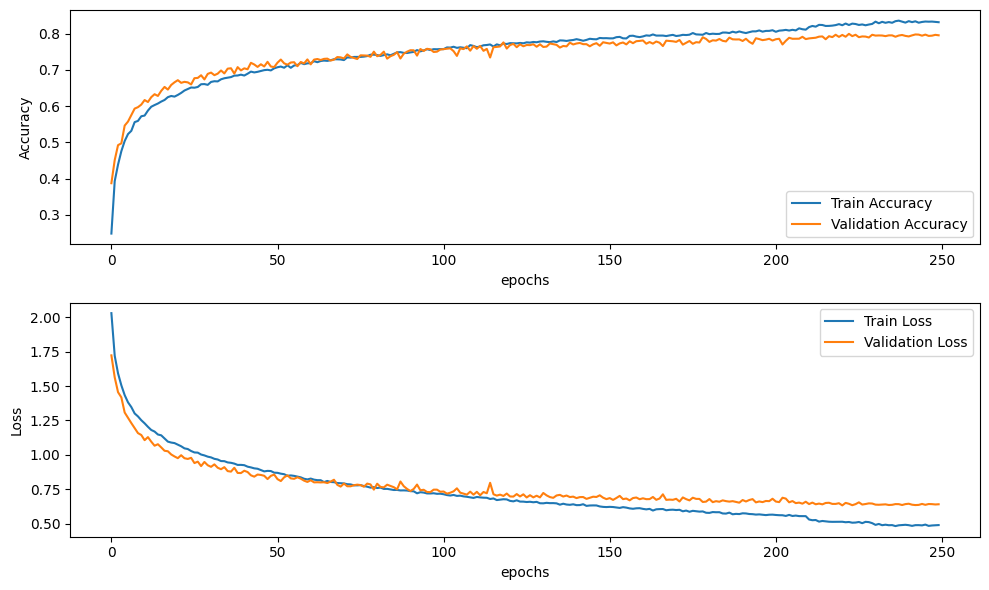

--------------------


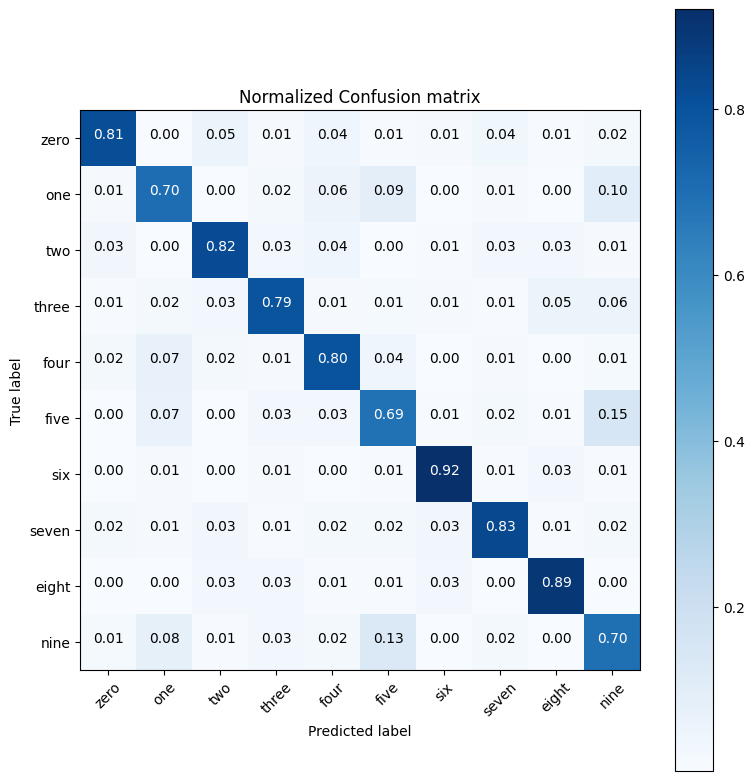

In [27]:
final_train_acc, final_train_loss, final_val_acc, final_val_loss, trained_net = start_experiment(plots=True, cmatrix=True)

Save performance values to csv

In [28]:
perf_dict = {'TRAIN_ACCURACY': final_train_acc,
             'TRAIN_LOSS': final_train_loss,
             'VAL_ACCURACY': final_val_acc,
             'VAL_LOSS': final_val_loss}

df = pd.DataFrame(perf_dict)

df.to_csv('perf.csv')



---

